In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm

In [2]:
""" 
Obtaining data from a given expt
"""
xls = pd.ExcelFile('dummy_task/data/js_dummy_task_2020_Oct_22_0954.xlsx')
df1 = pd.read_excel(xls, 'trials')
df2 = pd.read_excel(xls, 'test_trials')

In [3]:
"""
Get tones and values of keys pressed
"""
test_trial_columns = list(df2.columns)
tones_col_idx = test_trial_columns.index('Tones')
keys_cols_idxs = range(test_trial_columns.index('test_resp.keys_raw'),\
                       test_trial_columns.index('test_resp.rt_mean'))
corrans_col_idx = test_trial_columns.index('corrAns')
df_tones = (df2.iloc[1:50,tones_col_idx]).values
df_keys = (df2.iloc[1:50,keys_cols_idxs]).values
df_corrans = (df2.iloc[1:50,corrans_col_idx]).values

"""
Cleaning tones to give a single array with all tones
"""
tones_array = np.zeros((len(df_tones),1))
for i_tone in range(len(df_tones)):
    tones_array[i_tone,:] = np.array(df_tones[i_tone][1:-1].split(',')).astype(float)  \
    # slicing is based on the data obtained from .values
    

In [4]:
"""
Convert keys ['l','h'] to [0,1] and plot p(H|T)
"""
corrans_num = np.zeros_like(df_corrans)
corrans_num[df_corrans == 'h'] = 1

keys_num = np.zeros_like(df_keys)
keys_num[df_keys[:,0] == "'h'", 0] = 1
keys_num[df_keys[:,1] == " 'h'", 1] = 1
keys_num[df_keys[:,2] == " 'h'", 2] = 1
keys_num[df_keys[:,3] == " 'h'", 3] = 1

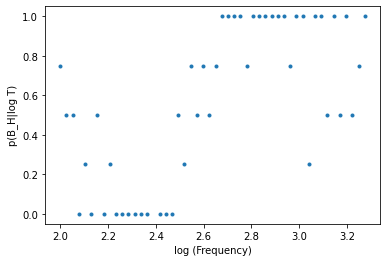

In [5]:
"""
For single tone
Since tones are repeated, plotting only unique tones and mean(keys) pairs 
"""
unique_tones, unique_index, unique_count = np.unique(tones_array, return_index = True, return_counts = True)
prob_high = np.zeros_like(unique_tones)

for i_cnt in range(len(unique_count)):
    indices = np.where(tones_array == unique_tones[i_cnt])[0][:]
    prob_high[i_cnt] = np.sum(np.sum(keys_num[indices,:],axis = 1))/(len(indices)*keys_num.shape[1])

fig = plt.figure()
ax = plt.subplot(111)
plt.plot(np.log10(unique_tones), prob_high,'.')
plt.xlabel('log (Frequency)')
plt.ylabel('p(B_H|log T)')

fig.savefig('p(B_H|log T) vs log(frequency) with no feedback.png')
#plt.plot(np.log10(tones_array), corrans_num, '.')

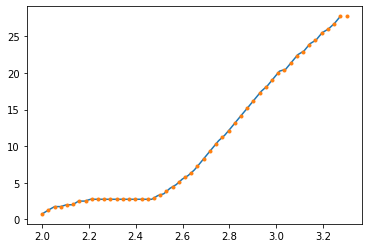

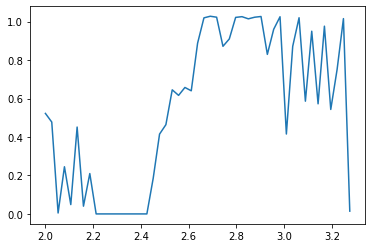

In [6]:
unique_tones_log10 = np.log10(unique_tones)
cdf_high = np.cumsum(prob_high)
x_log10_cleaned = np.linspace(np.log10(100),np.log10(2000))
y_log10_cleaned = np.interp(x_log10_cleaned,unique_tones_log10,cdf_high)
plt.plot(np.log10(unique_tones),np.cumsum(prob_high))
plt.plot(x_log10_cleaned, y_log10_cleaned,'.')
plt.show()
plt.plot(x_log10_cleaned[:-1], np.diff(y_log10_cleaned))

In [7]:
trial_tones = np.repeat(tones_array,keys_num.shape[1],axis = 0)
trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape))

expt_tones = np.arange(100,2000,1) #array of possible true tones
log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, \
                             np.log10(expt_tones[-1])+0.5, 0.05) # array of possible perceptual tones

In [8]:
print(trial_tones[0:20])
print(keys_num[:5,:],trial_behaviour[:20])

[[277.]
 [277.]
 [277.]
 [277.]
 [294.]
 [294.]
 [294.]
 [294.]
 [603.]
 [603.]
 [603.]
 [603.]
 [231.]
 [231.]
 [231.]
 [231.]
 [568.]
 [568.]
 [568.]
 [568.]]
[[0 0 0 0]
 [0 0 0 0]
 [1 0 1 1]
 [0 0 0 0]
 [1 1 1 1]] [0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1]


(0.0, 1.1)

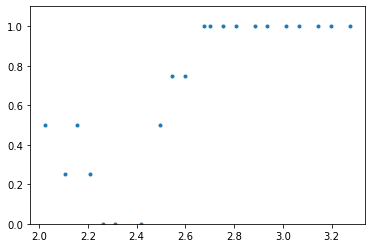

In [9]:
expt_tones_binned = np.linspace(np.log10(expt_tones[0]),np.log10(expt_tones[-1]),22)
prob_high_in_bin = np.zeros((len(expt_tones_binned),1))
unique_tone_in_bin = np.zeros((len(expt_tones_binned),1))
tones_in_bin = np.zeros((len(expt_tones_binned),1))
keys_num_in_bin = np.zeros((len(expt_tones_binned),keys_num.shape[1]))

for i_bin in range(len(expt_tones_binned)-1):
    idxs = (unique_tones_log10 <= expt_tones_binned[i_bin+1]) & (unique_tones_log10 > expt_tones_binned[i_bin])
    prob_high_in_bin[i_bin] = np.amax(prob_high[idxs])
    unique_tone_in_bin[i_bin] = unique_tones_log10[idxs][np.argmax(prob_high[idxs])]    
    idx_trial_tones = np.argmin(abs(10**unique_tone_in_bin[i_bin] - tones_array))
    tones_in_bin[i_bin] = tones_array[idx_trial_tones]
    keys_num_in_bin[i_bin,:] = keys_num[idx_trial_tones,:]

plt.plot(unique_tone_in_bin[:-1], prob_high_in_bin[:-1],'.')    
plt.ylim(0,1.1)

In [10]:
trial_tones_in_bin = np.repeat(tones_in_bin[:-1],keys_num_in_bin.shape[1],axis = 0)
trial_behaviour_in_bin = np.reshape(keys_num_in_bin[:-1,:],np.prod(keys_num_in_bin[:-1,:].shape))

In [11]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def posterior_array(log_freq_percept, n_tones, p_back, p_low, 
                    log_prior_low, log_prior_high):
    """
    Arguments: 
    log_freq_percept - range of all possible frequencies (percepts?)
    p_back - prob of background, p_low - prob of low condition
    log_prior_low - gaussian of low condition
    log_prior_high - gaussian of high condition
    """
    
    log_prior_low_mean = log_prior_low[0]; log_prior_low_sigma = log_prior_low[1];
    log_prior_high_mean = log_prior_high[0]; log_prior_high_sigma = log_prior_high[1];
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
    
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, posterior

In [12]:
# define mle function
def MLE(params):
    log_prior_low_mean, log_prior_low_sigma, log_prior_high_mean, log_prior_high_sigma, p_back = \
    params[0], params[1], params[2], params[3], params[4] # inputs are guesses at our parameters
    
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high #mixture model
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low #mixture model
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)

    if len(trial_tones[0]) == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif len(trial_tones[0]) == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
    
    p_low = 0.5 
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer  
       
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        if len(trial_tones[i_trial]) == 3: 
            input_array_0 = np.expand_dims(gaussian(log_freq_percept, \
                                                    mean = np.log10(trial_tones[i_trial][0]), \
                                                    sigma = 0.1), axis = 1)
            input_array_1 = np.expand_dims(gaussian(log_freq_percept, \
                                                    mean = np.log10(trial_tones[i_trial][1]), \
                                                    sigma = 0.1), axis = 1)
            input_array_2 = np.expand_dims(gaussian(log_freq_percept, \
                                                    mean = np.log10(trial_tones[i_trial][2]), \
                                                    sigma = 0.1), axis = 1)
            input_array_mat = np.expand_dims(input_array_0@np.transpose\
                                             (input_array_1),axis=2)@np.transpose(input_array_2) #p(T1,T2..|H)     
            input_array_mat /= np.sum(input_array_mat)
            probability_high0 = np.transpose(posterior)@input_array
            probability_high[i_trial] = np.transpose(posterior)@input_array
            
        elif len(trial_tones[i_trial]) == 1:
            for i_post in range(len(posterior)):
                input_array = gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][0]), sigma = 0.1)
                input_array /= np.sum(input_array)
                input_array = np.expand_dims(input_array, axis = 1)            
                probability_high0 = np.transpose(posterior)@input_array
                probability_high[i_trial] = np.transpose(posterior)@input_array
            # pdb.set_trace()
            
        if trial_behaviour[i_trial]:
            if np.isnan(probability_high0):
                pdb.set_trace()
            neg_ll += -np.log(probability_high0 + np.finfo(float).eps) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + np.finfo(float).eps) # if low dist is chosen by observer
    # pdb.set_trace()        
    return(neg_ll)

In [13]:
guess_low_mean = np.arange(2,2.5,0.05); guess_low_sigma = np.arange(0.05,0.2,0.05)
guess_high_mean = np.arange(2.6,3.1,0.05); guess_high_sigma = np.arange(0.05,0.2,0.05)
guess_p_back = np.arange(0.1,1,0.05)

# Constraining guesses of means of low and high distributions based on observed behaviour in figure shown above. 

neg_ll_array = np.zeros((len(guess_low_mean),len(guess_low_sigma),\
                         len(guess_high_mean),len(guess_high_sigma),len(guess_p_back)))
for lm in tqdm(range(len(guess_low_mean))):
    for ls in tqdm(range(len(guess_low_sigma)), leave=False, desc="Low sigma"):
        for hm in range(len(guess_high_mean)):
            for hs in range(len(guess_high_sigma)):
                for pb in range(len(guess_p_back)):
                    params = [guess_low_mean[lm], guess_low_sigma[ls], guess_high_mean[hm], \
                              guess_high_sigma[hs], guess_p_back[pb]]
                    # print(lm, hm, pb)
                    neg_ll_array[lm,ls,hm,hs,pb] = MLE(params)      

KeyboardInterrupt: 

In [23]:
"""
Means and p_back corresponding to the least negative log likelihood value
"""
idxs = np.where(neg_ll_array == np.amin(neg_ll_array)) 
guess_low_mean[idxs[0]], guess_low_sigma[idxs[1]],  guess_high_mean[idxs[2]], \
guess_high_sigma[idxs[3]], guess_p_back[idxs[4]]

(array([2.4]), array([0.1]), array([2.75]), array([0.1]), array([0.1]))

In [15]:
"""
True values of the means and stds 
"""
log_freq_seq_limits = [np.log10(expt_tones[0]), np.log10(expt_tones[-1])]
log_freq_seq_mid = np.mean(log_freq_seq_limits)
log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian 
log_freq_high = [log_freq_seq_mid + 0.2,0.1]
print(log_freq_low, log_freq_high)

[2.450406397059058, 0.1] [2.8504063970590585, 0.1]


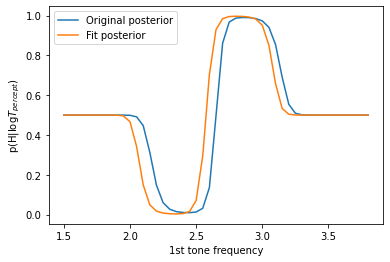

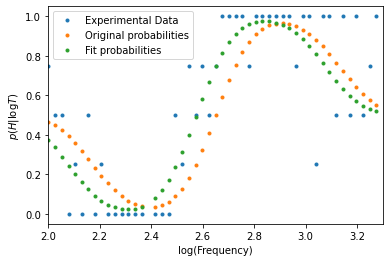

In [16]:
"""
Visualizing results from fitted parameters of one tone data
Perceptual tones have a longer range than the experimental tones.
"""

log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, np.log10(expt_tones[-1])+0.5, 0.05) 

prior_high,prior_low,posterior = \
posterior_array(log_freq_percept, n_tones=1, p_back=0.3, p_low=0.5, \
                log_prior_low=log_freq_low, log_prior_high=log_freq_high)
        
probability_sim_high = np.zeros((len(unique_tones),1))

i_trial = 0
for i_stim in range(len(unique_tones)):
    gaussian_prob_array = gaussian(log_freq_percept, mean = np.log10(unique_tones[i_stim]), sigma = 0.1)
    gaussian_prob_array /= np.sum(gaussian_prob_array)
    gaussian_prob_array = np.expand_dims(gaussian_prob_array, axis = 1)  
    probability_sim_high[i_stim] = np.transpose(posterior)@gaussian_prob_array
    
prior_high_fit,prior_low_fit,posterior_fit = \
posterior_array(log_freq_percept, n_tones=1, p_back=guess_p_back[idxs[4]], p_low=0.5, \
                log_prior_low=[guess_low_mean[idxs[0]],guess_low_sigma[idxs[1]]],\
                log_prior_high=[guess_high_mean[idxs[2]],guess_high_sigma[idxs[3]]])

fig = plt.figure()
ax = plt.axes()
ax.plot(log_freq_percept,posterior)
ax.plot(log_freq_percept,posterior_fit)
ax.legend(['Original posterior','Fit posterior'])
plt.xlabel('1st tone frequency')
plt.ylabel('p(H|$\log T_{percept}$)')
plt.show()      
        
probability_sim_high_fit = np.zeros((len(unique_tones),1))

i_trial = 0
for i_stim in range(len(unique_tones)):
    gaussian_prob_array = gaussian(log_freq_percept, mean = np.log10(unique_tones[i_stim]), sigma = 0.1)
    gaussian_prob_array /= np.sum(gaussian_prob_array)
    gaussian_prob_array = np.expand_dims(gaussian_prob_array, axis = 1)  
    probability_sim_high_fit[i_stim] = np.transpose(posterior_fit)@gaussian_prob_array
    
fig = plt.figure()
ax = plt.axes()
ax.plot(np.log10(unique_tones),prob_high,'.') 
ax.plot(np.log10(unique_tones),probability_sim_high,'.')
ax.plot(np.log10(unique_tones),probability_sim_high_fit,'.')
ax.legend(['Experimental Data','Original probabilities','Fit probabilities'])
plt.xlim(np.log10(expt_tones[0]),np.log10(expt_tones[-1]))
plt.ylabel('$p(H|\log T)$')
plt.xlabel('log(Frequency)')
plt.savefig("experiment_date={},multiplier={},n_tones={},n_trials={}".format\
            ("Oct220954", 20,len(unique_tones),keys_num.shape[1]))


In [ ]:
"""
For two tones
Since tones are repeated, plotting only unique tones and mean(keys) pairs 
"""
unique_tones, unique_index, unique_count = np.unique(tones_array, return_index = True, return_counts = True)
prob_high = np.zeros((len(unique_tones), len(unique_tones)))

for i_tone1 in range(len(unique_tones)):
    for i_tone2 in range(len(unique_tones)):
        indices = np.where(np.all(tones_array==[unique_tones[i_tone1], unique_tones[i_tone2]],axis=1))[0][:]
        if indices:
            prob_high[i_tone1,i_tone2] = np.sum(np.sum(keys_num[indices,:],axis = 1))/(len(indices)*keys_num.shape[1])
            # pdb.set_trace()

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = ax.imshow(prob_high, extent=[np.log10(unique_tones[0]),np.log10(unique_tones[-1]), \
                                        np.log10(unique_tones[-1]),np.log10(unique_tones[0])])
ax.invert_yaxis()
cbar = plt.colorbar(colormap, ax=ax)
ax.set_xlabel('1st tone frequency')
ax.set_ylabel('2nd tone frequency')